I/O, Util, Boilerplate

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
johnsonData = pd.read_excel("PHYS 214/Johnson Noise Measurements.xlsx")
shotNoiseData = pd.read_excel("PHYS 214/Shot Noise Data.xlsx")

Anomaly Detection

In [3]:
import sklearn.ensemble as ens

In [4]:
#workedJohnson = johnsonData.drop(
#    ['dR', 'dBandwidth', 'dVT', 'Output Standard Error', 'dProduct', 'Voltage Calc Error'], axis=1)
workedJohnson = johnsonData
workedshotNoise = shotNoiseData

In [5]:
jForest = ens.IsolationForest().fit(workedJohnson)
jresult = jForest.predict(workedJohnson)
sForest = ens.IsolationForest().fit(workedshotNoise)
sresult = sForest.predict(workedshotNoise)

In [6]:
jInliers = johnsonData[jresult == 1]
jOutliers = johnsonData[jresult == -1]
sInliers = shotNoiseData[sresult == 1]
sOutliers = shotNoiseData[sresult == -1]

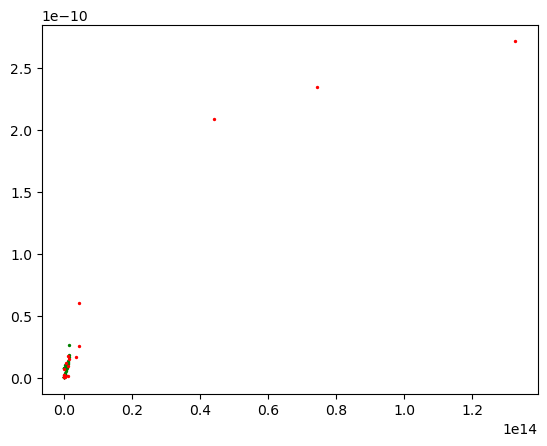

In [7]:
plt.scatter(jInliers['Product'], jInliers['Voltage'], color="green", s=2)
plt.scatter(jOutliers['Product'], jOutliers['Voltage'], color="red", s=2)

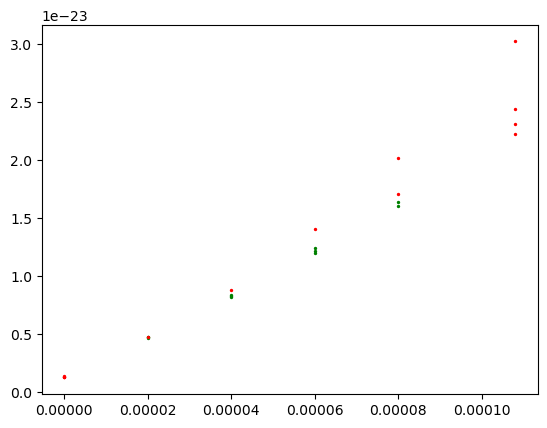

In [8]:
plt.scatter(sInliers['Idc'], sInliers['delsq2f'], color="green", s=2)
plt.scatter(sOutliers['Idc'], sOutliers['delsq2f'], color="red", s=2)

Curve Fitting

In [9]:
#Linear Fitting
def lin(B, x):
    #m*x + b
    return B[0]*x + B[1]

linModel = sp.odr.Model(lin)

In [10]:
#johnsonFitData = sp.odr.RealData(jInliers['Product'].to_numpy(), jInliers['Voltage'].to_numpy(), 
#                             sx=jInliers['dProduct'].to_numpy(), sy=jInliers['Voltage Calc Error'].to_numpy())
johnsonFitData = sp.odr.Data(jInliers['Product'].to_numpy(), jInliers['Voltage'].to_numpy(), 
                             wd=1/jInliers['dProduct'].to_numpy(), we=1/jInliers['Voltage Calc Error'].to_numpy())
johnsonRegression = sp.odr.ODR(johnsonFitData, linModel, beta0=[1.23E-23, 1.4E-12])

In [11]:
shotNoiseFitData = sp.odr.Data(sInliers['Idc'].to_numpy(), sInliers['delsq2f'].to_numpy(), 
                             wd=1/sInliers['dIdc'].to_numpy(), we=1/sInliers['ddelsq2f'].to_numpy())
shotNoiseFitData = sp.odr.ODR(shotNoiseFitData, linModel, beta0=[1.33E-24, 1.8E-19])

In [12]:
out = johnsonRegression.run()
sout = shotNoiseFitData.run()

In [13]:
out.pprint()
sout.pprint()

Beta: [1.40658716e-23 1.96057845e-12]
Beta Std Error: [1.82469995e-24 4.49550773e-13]
Beta Covariance: [[ 2.14904491e-39 -2.40440378e-28]
 [-2.40440378e-28  1.30442787e-16]]
Residual Variance: 1.5493068082067503e-09
Inverse Condition #: 0.4086755552797512
Reason(s) for Halting:
  Sum of squares convergence
Beta: [1.88545795e-19 8.60041215e-25]
Beta Std Error: [2.43509946e-21 1.11605372e-25]
Beta Covariance: [[ 3.71624406e-18 -1.53071719e-22]
 [-1.53071719e-22  7.80622416e-27]]
Residual Variance: 1.5956189357697778e-24
Inverse Condition #: 1.4850755121934046e-10
Reason(s) for Halting:
  Sum of squares convergence


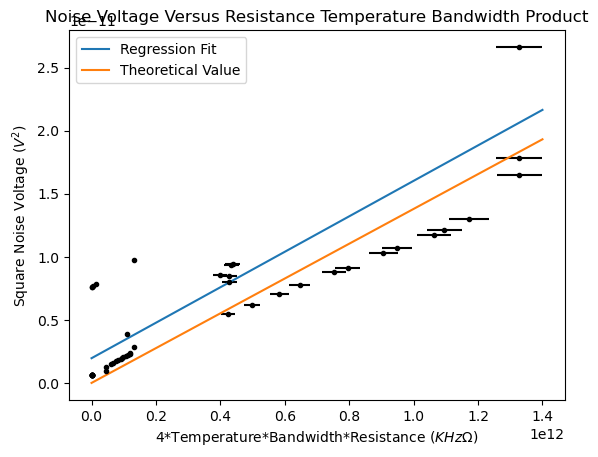

In [32]:
plt.errorbar(jInliers['Product'].to_numpy(), jInliers['Voltage'].to_numpy(), 
                             xerr=jInliers['dProduct'].to_numpy(), yerr=jInliers['Voltage Calc Error'].to_numpy(),
            linestyle='None', fmt='ko', markersize=3)
xfine = np.linspace(0, 1.4E12, 10000)
plt.plot(xfine, out.beta[0]*xfine + out.beta[1], label="Regression Fit")
plt.plot(xfine, xfine*1.38E-23, label="Theoretical Value")

plt.title("Noise Voltage Versus Resistance Temperature Bandwidth Product")
plt.ylabel(r"Square Noise Voltage ($V^2$)")
plt.xlabel(r"4*Temperature*Bandwidth*Resistance ($KHz\Omega$)")
plt.legend()
plt.show()

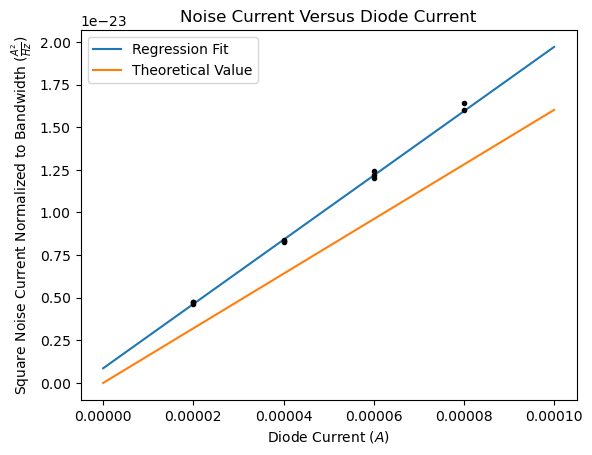

In [33]:
plt.errorbar(sInliers['Idc'].to_numpy(), sInliers['delsq2f'].to_numpy(), 
                             xerr=sInliers['dIdc'].to_numpy(), yerr=sInliers['ddelsq2f'].to_numpy(),
            linestyle='None', fmt='ko', markersize=3)
xfine = np.linspace(0, 1E-4, 10000)
plt.plot(xfine, sout.beta[0]*xfine + sout.beta[1], label="Regression Fit")
plt.plot(xfine, xfine*1.602E-19, label="Theoretical Value")


plt.title("Noise Current Versus Diode Current")
plt.ylabel(r"Square Noise Current Normalized to Bandwidth ($\frac{A^2}{Hz}$)")
plt.xlabel(r"Diode Current ($A$)")
plt.legend()
plt.show()